In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
params = {
    'meta-llama/Llama-3.1-8B-Instruct': 8,
    'Qwen/Qwen3-8B':8,
    'google/gemma-2-9b-it':9,
    'Qwen/Qwen3-14B':14,
    'mistralai/Ministral-8B-Instruct-2410':8,
    'Qwen/QwQ-32B':32,
    'Qwen/Qwen3-32B':32,
    'mistralai/Mistral-Small-3.1-24B-Instruct-2503': 24,
    'google/gemma-2-27b-it':27,
    'meta-llama/Llama-3.3-70B-Instruct':70,
    'nvidia/Llama-3_3-Nemotron-Super-49B-v1':49,
    'Qwen/Qwen2-72B-Instruct':72,
    'mistralai/Mixtral-8x7B-Instruct-v0.1': 56,
    'mistralai/Mixtral-8x22B-Instruct-v0.1': 8*22,
    'meta-llama/Llama-4-Scout-17B-16E-Instruct': 16*17,
    'Qwen/Qwen3-235B-A22B-FP8' : 235,
    'deepseek-ai/DeepSeek-R1-0528' : 670,
}

In [49]:
df = pd.read_csv('dataset_inference_results_ep.csv')

mask = df['EP'] == True
df.loc[mask, 'EP'] = df.loc[mask, 'TP Size']
df.loc[mask, 'TP Size'] = 1

mask = df['EP'] == False
df.loc[mask, 'EP'] = 1

df.to_csv('dataset_inference_results_ep.csv', index=False)

In [50]:
df = pd.read_csv('dataset_inference_results.csv')

df.keys()

Index(['active_energy', 'total_energy', 'active_power_avg',
       'active_power_peak', 'active_power_p50', 'active_power_p95',
       'total_power_avg', 'total_power_peak', 'total_power_p50',
       'total_power_p95', 'active_gpu_util_avg', 'active_gpu_util_peak',
       'active_gpu_util_p50', 'active_gpu_util_p95', 'active_mem_avg',
       'active_mem_peak', 'active_mem_p50', 'active_mem_p95', 'total_mem_avg',
       'total_mem_peak', 'total_mem_p50', 'total_mem_p95',
       'total_gpu_util_avg', 'total_gpu_util_peak', 'total_gpu_util_p50',
       'total_gpu_util_p95', 'In Tokens Total', 'In Tokens Avg',
       'In Tokens P50', 'In Tokens P95', 'In Tokens Max', 'In Tokens Min',
       'Out Tokens Total', 'Out Tokens Avg', 'Out Tokens P50',
       'Out Tokens P95', 'Out Tokens Max', 'Out Tokens Min',
       'Latency Total (s)', 'Latency Avg (s)', 'Latency P50 (s)',
       'Latency P95 (s)', 'Latency Max (s)', 'Latency Min (s)', 'TTFT Avg (s)',
       'TTFT P50 (s)', 'TTFT P95 (s)', 'T

In [51]:
df.sort_values(by=['Hardware type','Model Name','TP Size', 'EP'], ascending=True, inplace=True)

df = df.drop_duplicates(
    subset=['Hardware type', 'Model Name', 'TP Size', 'EP', 'Batch Size'],
)

df['Precision'] = 'bfloat16'

df.to_csv('dataset_inference_results.temp.csv', index=False)

In [52]:
df['Tokens Total'] = df['In Tokens Total'] + df['Out Tokens Total']
df['Active Energy/Tok (in+out) J/1000'] = df['active_energy'] / df['Tokens Total'] * 1000
df['Active Energy/Tok (in) J/1000'] = df['active_energy'] / df['In Tokens Total'] * 1000
df['Active Energy/Tok (out) J/1000'] = df['active_energy'] / df['Out Tokens Total'] * 1000

df['# params'] = df.apply(lambda x: params[x['Model Name']], axis=1)
df['Is MoE'] = df['Model Name'].isin([
    'meta-llama/Llama-4-Scout-17B-16E-Instruct',
    'mistralai/Mixtral-8x7B-Instruct-v0.1',
    'mistralai/Mixtral-8x22B-Instruct-v0.1',
    ]) 

df['Throughput per Watt'] = df['Throughput (out) tok/s'] / df['active_power_avg']

def shorten_name(name):
    return name.split('/')[-1].replace('-', ' ').replace('Instruct', '').replace('it', '').replace('2503','').replace('2410','').strip()

df['Model Name Short'] = df['Model Name'].apply(shorten_name)

In [53]:
# Define grouping keys
group_keys = ['Model Name', 'Hardware type', 'Batch Size', 'Precision']

# Create a new column in original df by merging the baseline latency
baseline_latency = (
    df[df['TP Size'] == 1]
    .set_index(group_keys)['Throughput (in+out) tok/s']
    .rename('Baseline TP')
)

# Merge baseline latency back into the original df
df = df.merge(baseline_latency, on=group_keys, how='left')

# Calculate scaling efficiency
df['Scaling efficiency'] = (
    df['Throughput (in+out) tok/s'] / (df['Baseline TP'] * df['TP Size'])
)

In [54]:
models   = df['Model Name'].unique()

models

array(['Qwen/QwQ-32B', 'Qwen/Qwen2-72B-Instruct', 'Qwen/Qwen3-14B',
       'Qwen/Qwen3-235B-A22B-FP8', 'Qwen/Qwen3-32B', 'Qwen/Qwen3-8B',
       'deepseek-ai/DeepSeek-R1-0528', 'google/gemma-2-27b-it',
       'google/gemma-2-9b-it', 'meta-llama/Llama-3.1-8B-Instruct',
       'meta-llama/Llama-3.3-70B-Instruct',
       'meta-llama/Llama-4-Scout-17B-16E-Instruct',
       'mistralai/Ministral-8B-Instruct-2410',
       'mistralai/Mistral-Small-3.1-24B-Instruct-2503',
       'mistralai/Mixtral-8x22B-Instruct-v0.1',
       'mistralai/Mixtral-8x7B-Instruct-v0.1',
       'nvidia/Llama-3_3-Nemotron-Super-49B-v1'], dtype=object)

In [55]:
hw_types = df['Hardware type'].unique()

hw_types

array(['AMD Instinct MI300X', 'Intel(R) Data Center GPU Max 1550',
       'NVIDIA A100-SXM4-80GB', 'NVIDIA A40', 'NVIDIA H100 80GB HBM3'],
      dtype=object)

In [56]:
tp_sizes = df['TP Size'].unique()
tp_sizes

array([1, 2, 4, 8])

In [57]:
ep_sizes = df['EP'].unique()
ep_sizes

array([1, 4, 8, 2])

### TO DO

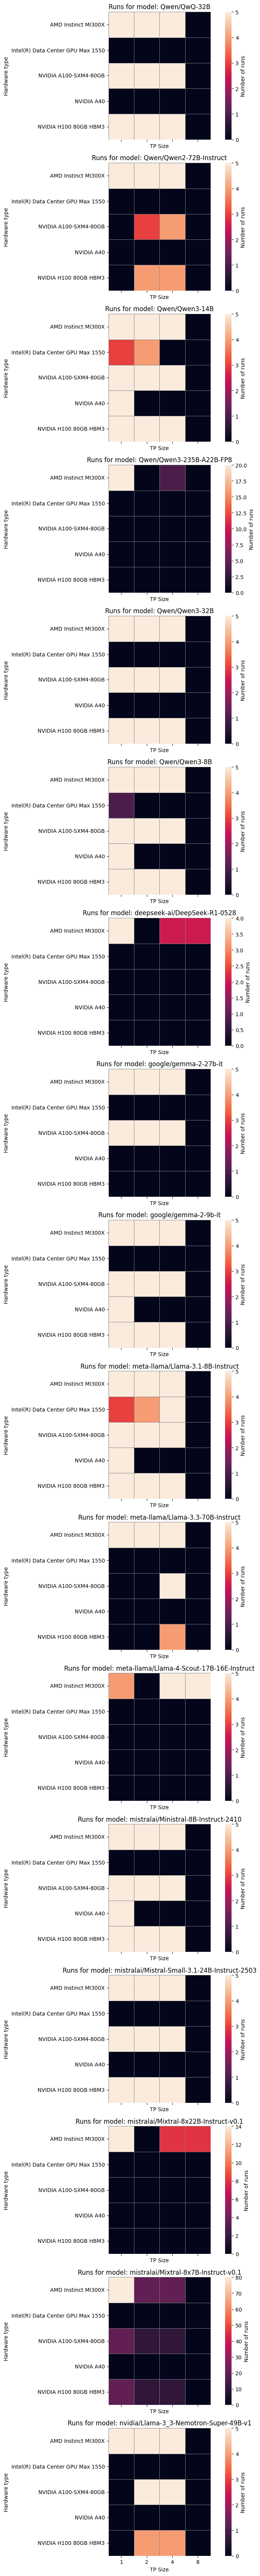

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Enumerate all levels so that missing combinations become zeros
hw_types = df['Hardware type'].unique()
tp_sizes = df['TP Size'].unique()
models   = df['Model Name'].unique()

all_idx = pd.MultiIndex.from_product(
    [hw_types, tp_sizes, models],
    names=['Hardware type', 'TP Size', 'Model Name']
)

# 2) Count how many runs you have per triplet
counts = df.groupby(
    ['Hardware type','TP Size','Model Name']
).size()

# 3) Reindex to include every possible triplet (fill missing with 0)
counts = counts.reindex(all_idx, fill_value=0)

# 4) Turn into a DataFrame for easy pivoting
counts_df = counts.rename('runs').reset_index()

# 5) For each model, pivot and plot a heatmap of run‑counts
n_models = len(models)
fig, axes = plt.subplots(n_models, 1, figsize=(8, 4*n_models), sharex=True)

if n_models == 1:
    axes = [axes]

for ax, model in zip(axes, models):
    mat = (
        counts_df
        .query("`Model Name` == @model")
        .pivot(index='Hardware type',
               columns='TP Size',
               values='runs')
    )
    sns.heatmap(
        mat,
        ax=ax,
        cbar_kws={'label': 'Number of runs'},
        linewidths=.5,
        linecolor='gray',
        square=True,
        # you can choose a different cmap for counts, e.g. "viridis"
    )
    ax.set_title(f"Runs for model: {model}")
    ax.set_ylabel("Hardware type")
    ax.set_xlabel("TP Size")

plt.tight_layout()
plt.show()


In [59]:
for hw in df['Hardware type'].unique():
    print(f"Hardware: {hw}")
    print('   ', len(df[df['Hardware type'] == hw]), "runs")
    print('   ', df[df['Hardware type'] == hw]['Model Name Short'].unique())
    print('   ', df[df['Hardware type'] == hw]['TP Size'].unique())

Hardware: AMD Instinct MI300X
    376 runs
    ['QwQ 32B' 'Qwen2 72B' 'Qwen3 14B' 'Qwen3 235B A22B FP8' 'Qwen3 32B'
 'Qwen3 8B' 'DeepSeek R1 0528' 'gemma 2 27b' 'gemma 2 9b' 'Llama 3.1 8B'
 'Llama 3.3 70B' 'Llama 4 Scout 17B 16E' 'Ministral 8B'
 'Mistral Small 3.1 24B' 'Mixtral 8x22B  v0.1' 'Mixtral 8x7B  v0.1'
 'Llama 3_3 Nemotron Super 49B v1']
    [1 2 4 8]
Hardware: Intel(R) Data Center GPU Max 1550
    20 runs
    ['Qwen3 14B' 'Qwen3 8B' 'Llama 3.1 8B']
    [1 2 4]
Hardware: NVIDIA A100-SXM4-80GB
    197 runs
    ['QwQ 32B' 'Qwen2 72B' 'Qwen3 14B' 'Qwen3 32B' 'Qwen3 8B' 'gemma 2 27b'
 'gemma 2 9b' 'Llama 3.1 8B' 'Llama 3.3 70B' 'Ministral 8B'
 'Mistral Small 3.1 24B' 'Mixtral 8x7B  v0.1'
 'Llama 3_3 Nemotron Super 49B v1']
    [1 2 4]
Hardware: NVIDIA A40
    25 runs
    ['Qwen3 14B' 'Qwen3 8B' 'gemma 2 9b' 'Llama 3.1 8B' 'Ministral 8B']
    [1]
Hardware: NVIDIA H100 80GB HBM3
    180 runs
    ['QwQ 32B' 'Qwen2 72B' 'Qwen3 14B' 'Qwen3 32B' 'Qwen3 8B' 'gemma 2 9b'
 'Llama 3.1 8B' '

### Utils

In [60]:
hardware_types = ['AMD Instinct MI300X', 'NVIDIA A100-SXM4-80GB', 'NVIDIA H100 80GB HBM3', 'NVIDIA A40']

colors = {
    'AMD Instinct MI300X': 'tab:blue',
    'NVIDIA A100-SXM4-80GB': 'tab:orange',
    'NVIDIA H100 80GB HBM3': 'tab:green',
    'NVIDIA A40': 'tab:red'
}
markers = {1: 'o', 2 : 's', 4: '^'}

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric(df, model_name, metric):
    model_df = df[df['Model Name'] == model_name].copy()
    model_df['Batch Size'] = model_df['Batch Size'].fillna(256)

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=model_df,
        x='Batch Size',
        y=metric,
        hue='Hardware type',
        style='TP Size',
        markers=True,
        dashes=True,
        ci=None,
        palette='viridis'         
    )

    plt.xlabel('Batch Size')
    plt.ylabel(metric)
    plt.title(f'{model_name}: {metric} by Batch Size, Hardware Type & TP Size')
    plt.grid(True, which='major', linestyle='--', alpha=0.5)
    plt.legend(title='HW / TP', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_trend(df, metric):
    model_df = df[(df['Batch Size'].isna()) & (df['Is MoE'] == False)].copy()

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=model_df,
        x='# params',
        y=metric,
        hue='Hardware type',
        style='TP Size',
        markers=True,
        dashes=True,
        ci=None,
        palette='viridis'     
    )

    plt.xscale('log')
    plt.xlabel('# params')
    plt.ylabel(metric)
    plt.title(f'{metric} by # params, Hardware Type & TP Size')
    plt.grid(True, which='major', linestyle='--', alpha=0.5)
    plt.legend(title='HW / TP', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def tp_vs_ep_metric(df, model_name, hw, metric):
    model_df = df[(df['Model Name'] == model_name) & (df['Hardware type'] == hw)].copy()

    if len(model_df) == 0:
        return

    model_df['Batch Size'] = model_df['Batch Size'].fillna(256)
    model_df["GPUs"]  = model_df['TP Size'].astype(int) * model_df['EP'].astype(int)
    model_df['is EP'] = model_df['EP'].astype(int) > 1

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=model_df,
        x='Batch Size',
        y=metric,
        hue='GPUs',
        style='is EP',
        markers=True,
        dashes=True,
        ci=None,
        palette='viridis',
    )

    plt.xlabel('Batch Size')
    plt.ylabel(metric)
    plt.title(f'{model_name} on {hw}: {metric} by Batch Size, TP Size & EP')
    plt.grid(True, which='major', linestyle='--', alpha=0.5)
    plt.legend(title='# GPUs  (style=EP)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### Metrics by model

/tmp/ipykernel_230121/2146343399.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


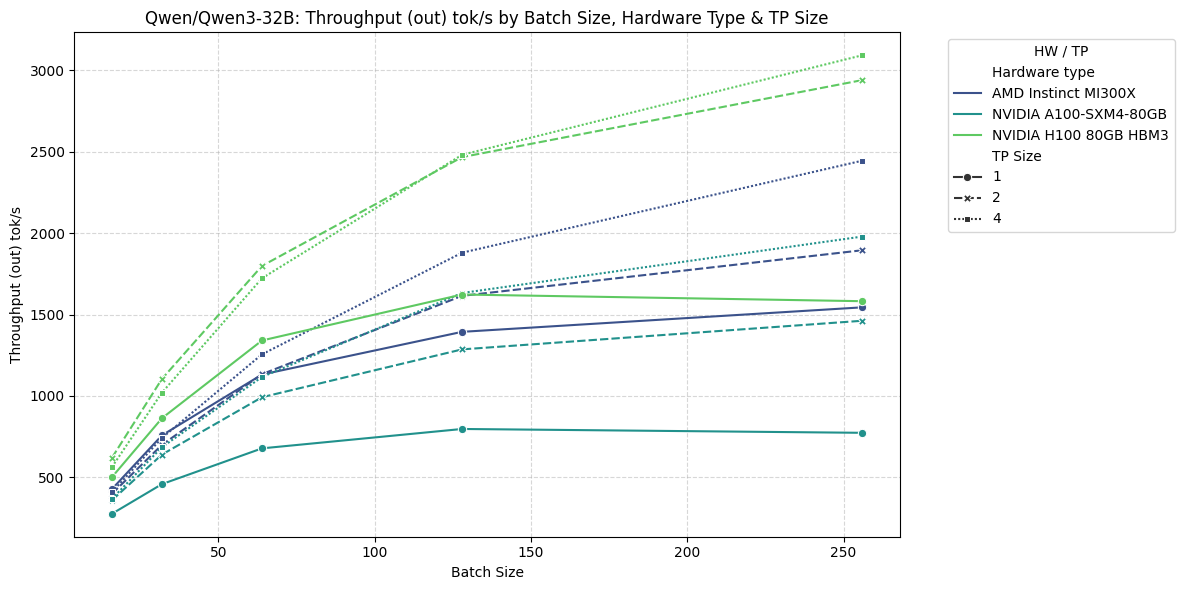

/tmp/ipykernel_230121/2146343399.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


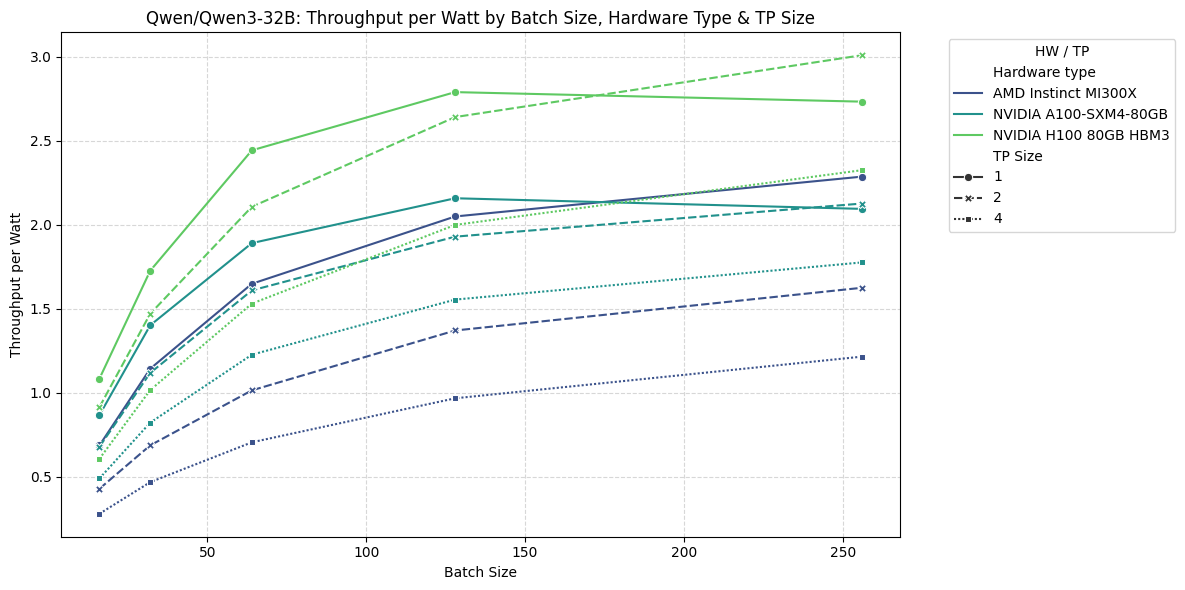

/tmp/ipykernel_230121/2146343399.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


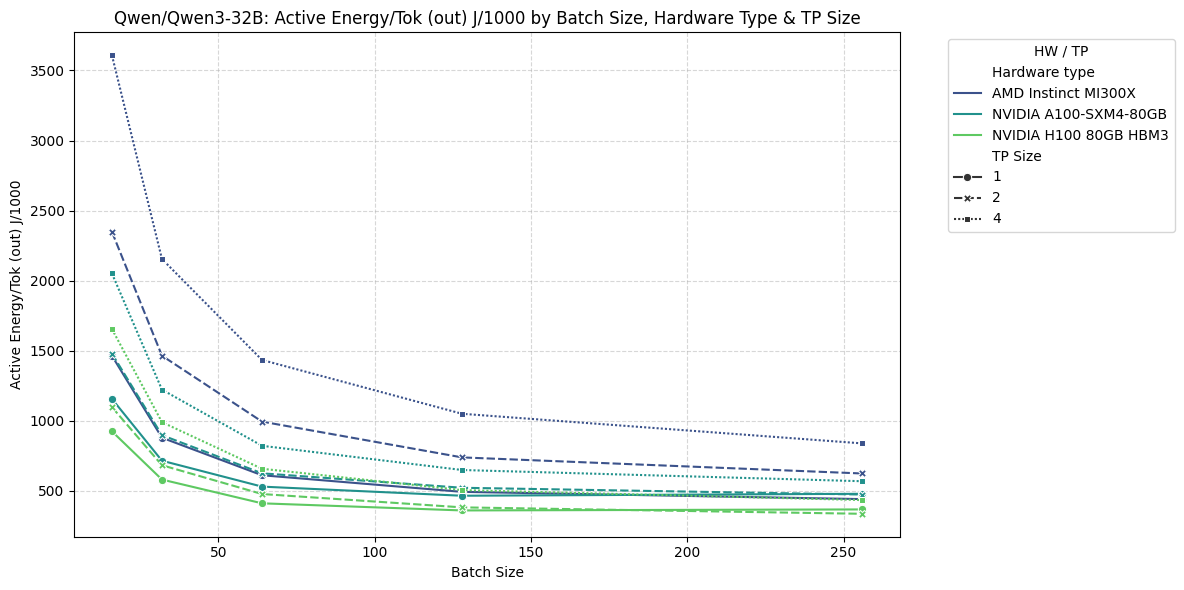

/tmp/ipykernel_230121/2146343399.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


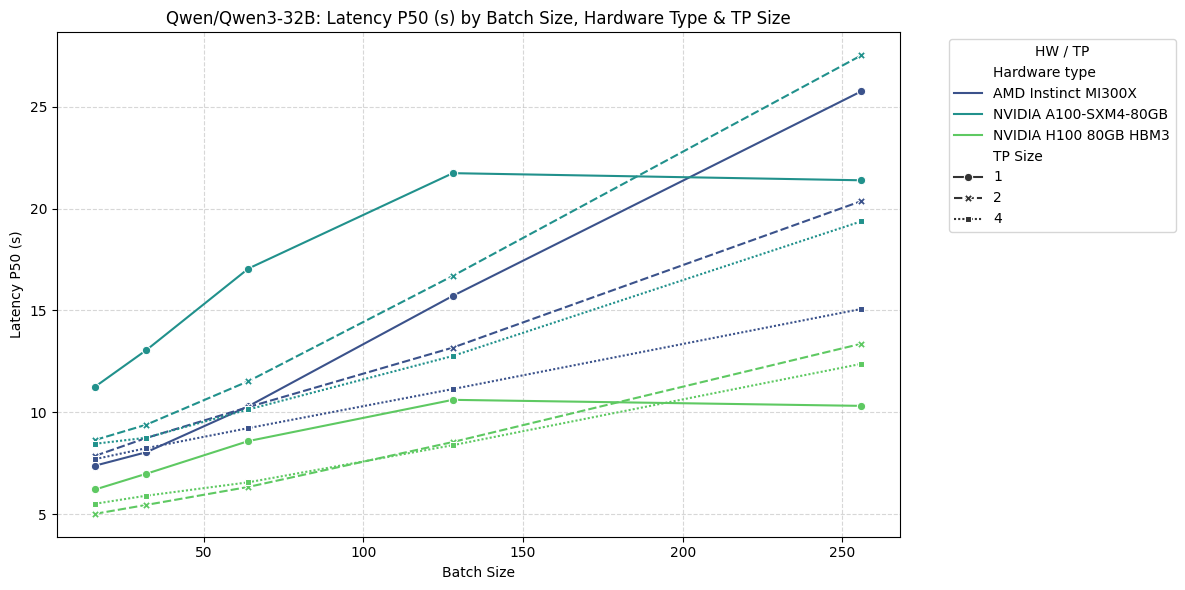

/tmp/ipykernel_230121/2146343399.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


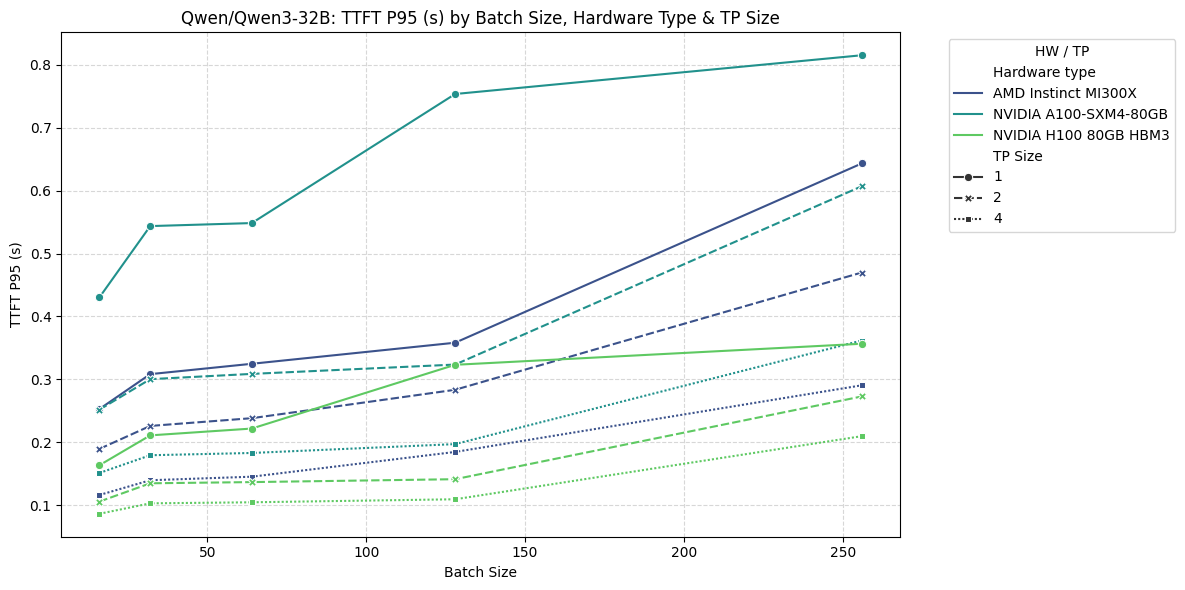

/tmp/ipykernel_230121/2146343399.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


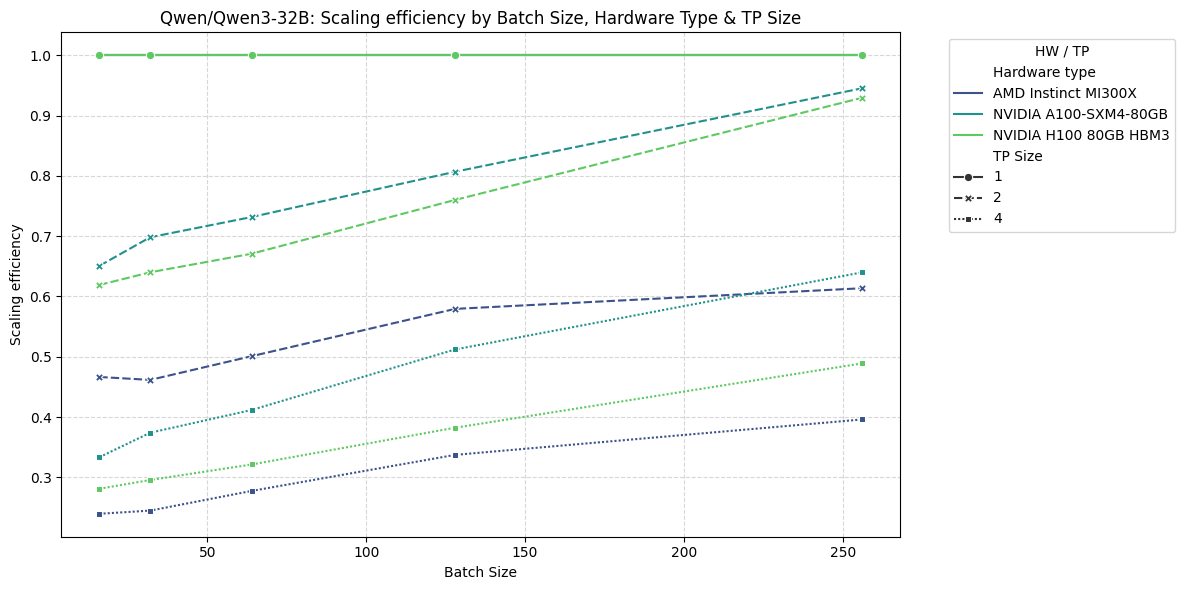

In [62]:
metrics = [
    'Throughput (out) tok/s',
    'Throughput per Watt',
    'Active Energy/Tok (out) J/1000',
    'Latency P50 (s)',
    'TTFT P95 (s)',
    'Scaling efficiency',
]

models = ['Qwen/Qwen3-32B']

for model_name in models:
    for metric in metrics:
        plot_metric(df, model_name, metric)

In [63]:
data = df.drop(columns=['Model Name', 'Model Name Short', 'FrameWork', 'Hardware type','In Tokens Total',
       'In Tokens Avg', 'In Tokens P50', 'In Tokens P95', 'In Tokens Max',
       'In Tokens Min', 'Out Tokens Total', 'Out Tokens Avg', 'Out Tokens P50',
       'Out Tokens P95', 'Out Tokens Max', 'Out Tokens Min', 'PP Size', 'EP'])  

plt.figure(figsize=(16, 12))
sns.heatmap(
    data.corr(method="spearman"),
    #annot=True,        # Show the correlation coefficient in each cell
    #fmt=".2f",         # Format numbers to two decimal places
    cmap="coolwarm",   # Color palette (blue = low, red = high by default)
    linewidths=0.5     # Lines between cells
)
plt.title("Correlation Heatmap")
plt.show()

ValueError: could not convert string to float: 'bfloat16'

<Figure size 1600x1200 with 0 Axes>

### Trend across sizes

/tmp/ipykernel_222914/1744640210.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


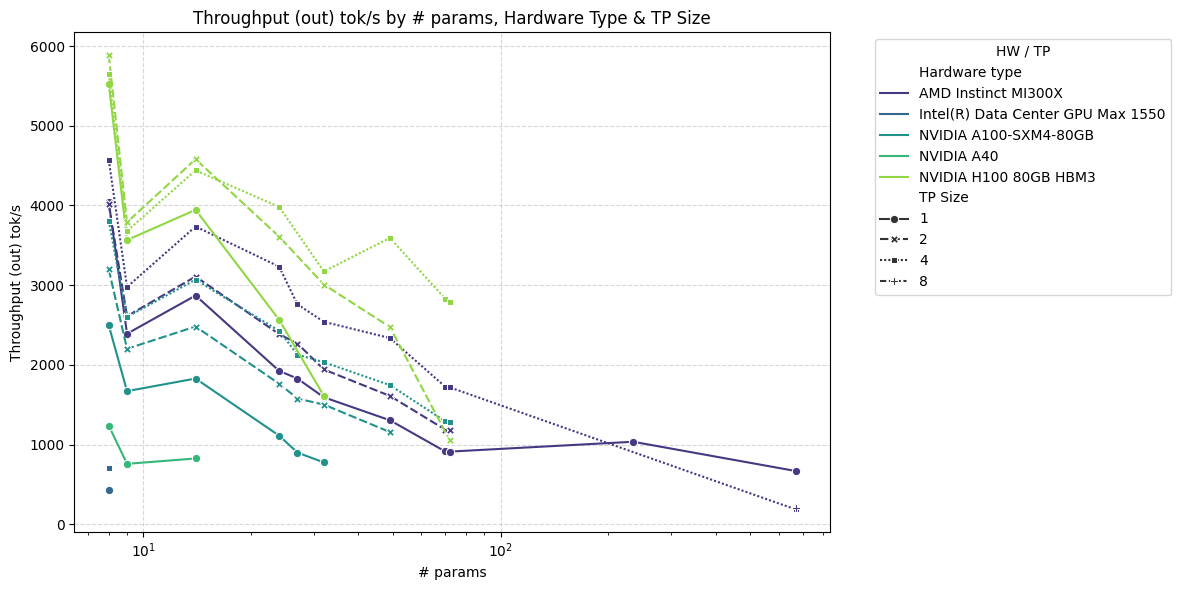

/tmp/ipykernel_222914/1744640210.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


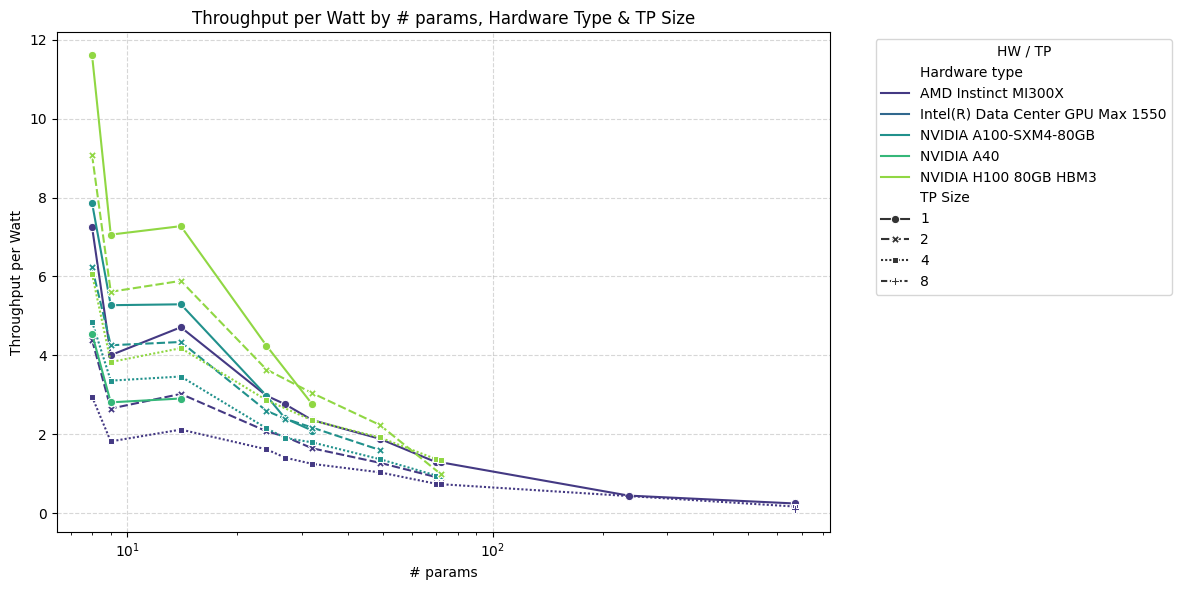

/tmp/ipykernel_222914/1744640210.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


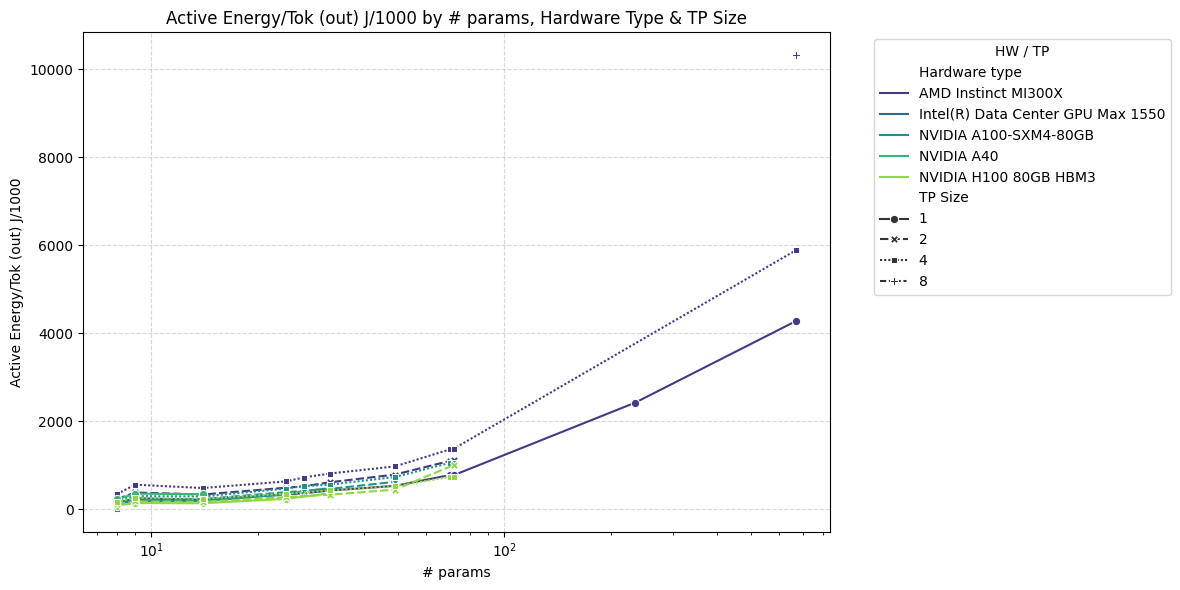

/tmp/ipykernel_222914/1744640210.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


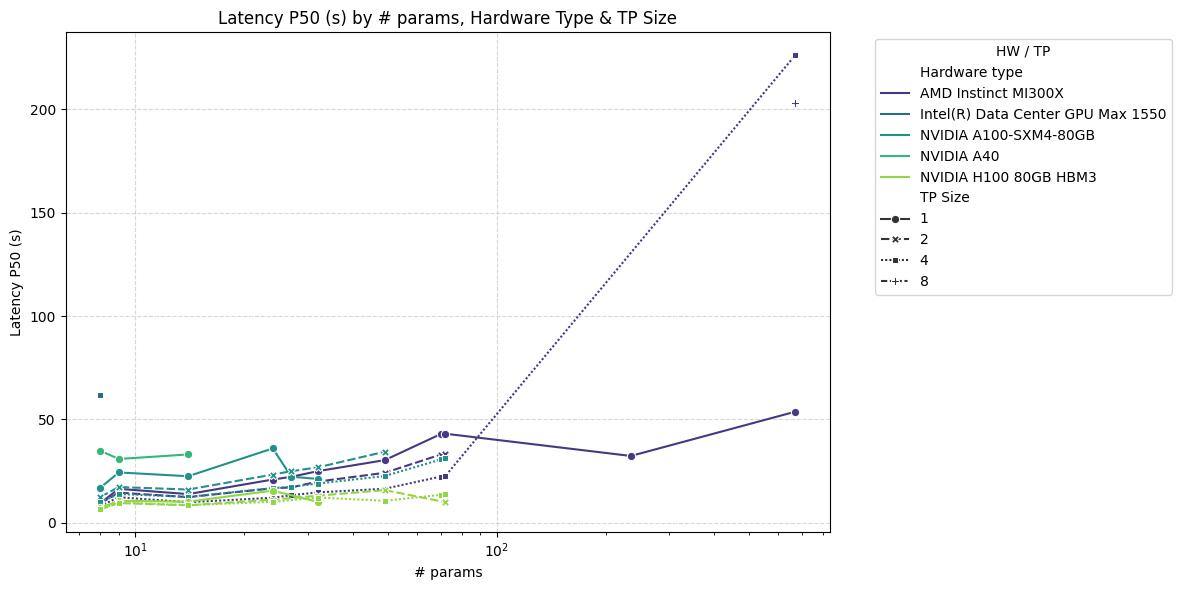

/tmp/ipykernel_222914/1744640210.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


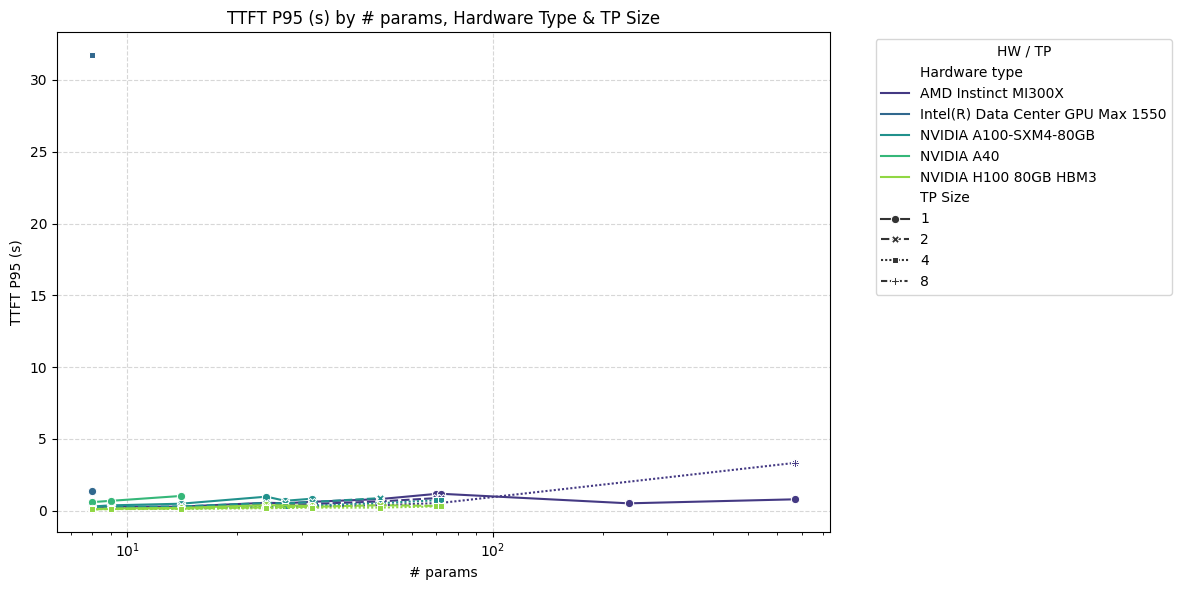

/tmp/ipykernel_222914/1744640210.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


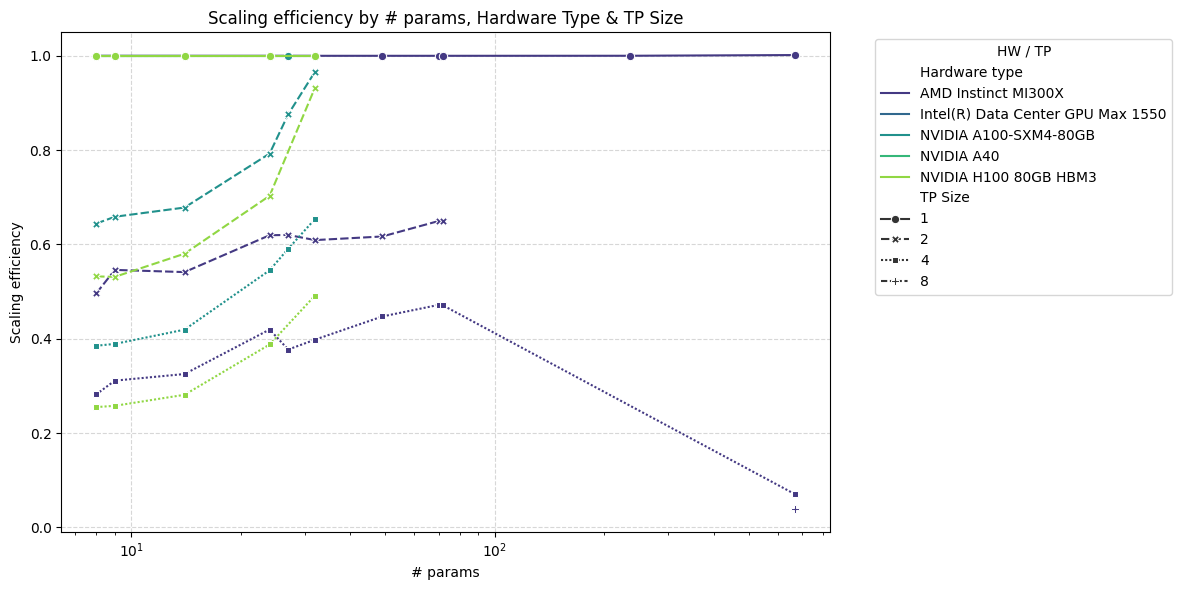

In [ ]:
metrics = [
    'Throughput (out) tok/s',
    'Throughput per Watt',
    'Active Energy/Tok (out) J/1000',
    'Latency P50 (s)',
    'TTFT P95 (s)',
    'Scaling efficiency',
]

for metric in metrics:
    plot_trend(df, metric)

### TP or EP

/tmp/ipykernel_230121/1947465941.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


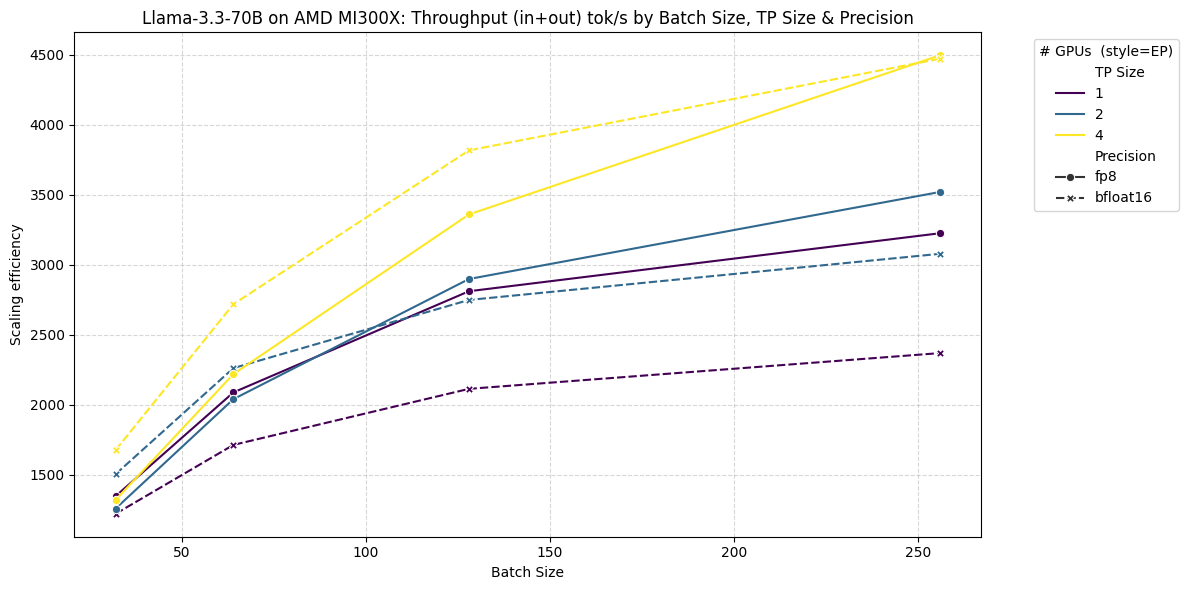

In [73]:
df_fp8 = pd.read_csv("results_fp8.csv")
df_fp8['Batch Size'] = df_fp8['Batch Size'].fillna(256)

df_bf16 = df[(df['Model Name'] == 'meta-llama/Llama-3.3-70B-Instruct') & (df['Hardware type'] == 'AMD Instinct MI300X') & (df['Batch Size'] != 16) ].copy()
df_bf16['Batch Size'] = df_bf16['Batch Size'].fillna(256)

concat_df = pd.concat([df_fp8, df_bf16], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=concat_df,
    x='Batch Size',
    y='Throughput (in+out) tok/s',
    hue='TP Size',
    style='Precision',
    markers=True,
    dashes=True,
    ci=None,
    palette='viridis',
)

plt.xlabel('Batch Size')
plt.ylabel(metric)
plt.title(f'Llama-3.3-70B on AMD MI300X: Throughput (in+out) tok/s by Batch Size, TP Size & Precision')
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.legend(title='# GPUs  (style=EP)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_230121/3627086040.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


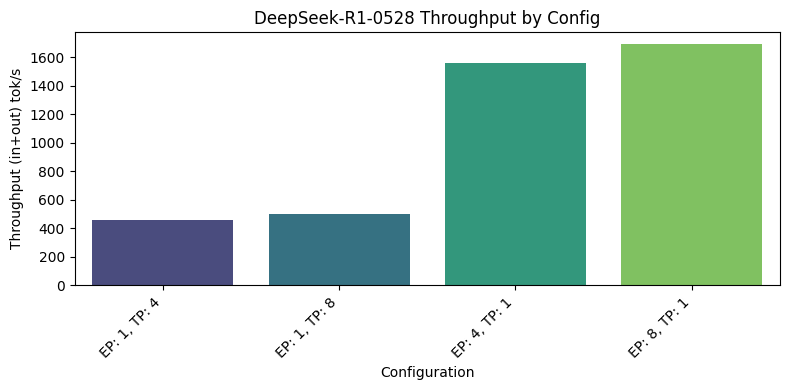

In [ ]:
# filter the dataframe
ds_df = df[df["Model Name"] == 'deepseek-ai/DeepSeek-R1-0528'].copy()

# build a per-row “config” string (fixed quoting and using ds_df, not df)
ds_df["config"] = ds_df.apply(
    lambda r: f"EP: {r['EP']}, TP: {r['TP Size']}", axis=1
)

# sort by throughput if you like
ds_df = ds_df.sort_values("Throughput (in+out) tok/s")

# set up the figure size for readability
plt.figure(figsize=(8, 4))

# draw the barplot
sns.barplot(
    data=ds_df,
    x='config',
    y='Throughput (in+out) tok/s',
    palette='viridis'
)

# rotate x-labels so they don’t overlap
plt.xticks(rotation=45, ha='right')

# add axis labels and title
plt.xlabel("Configuration")
plt.ylabel("Throughput (in+out) tok/s")
plt.title("DeepSeek-R1-0528 Throughput by Config")

plt.tight_layout()
plt.show()

In [ ]:
ds_df[["config", "Throughput (in+out) tok/s"]]

,config,Throughput (in+out) tok/s
103,"EP: 1, TP: 4",457.261994
104,"EP: 1, TP: 4",457.261994
105,"EP: 1, TP: 8",497.946483
106,"EP: 1, TP: 8",497.946483
99,"EP: 4, TP: 1",1560.685948
100,"EP: 4, TP: 1",1560.685948
101,"EP: 8, TP: 1",1690.510522
102,"EP: 8, TP: 1",1690.510522


/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


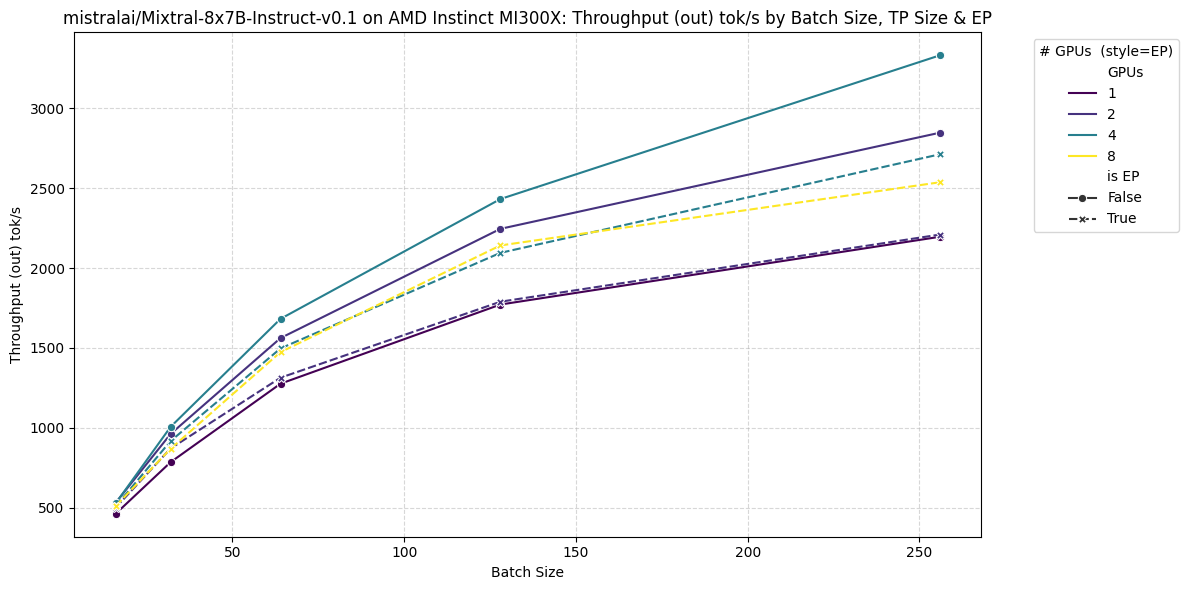

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


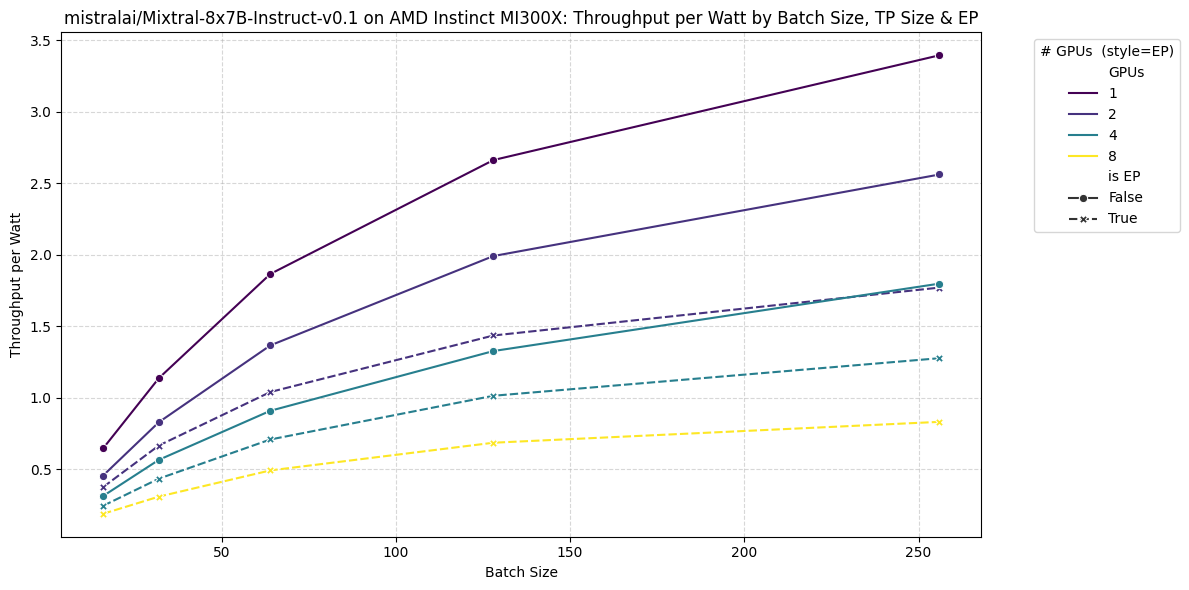

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


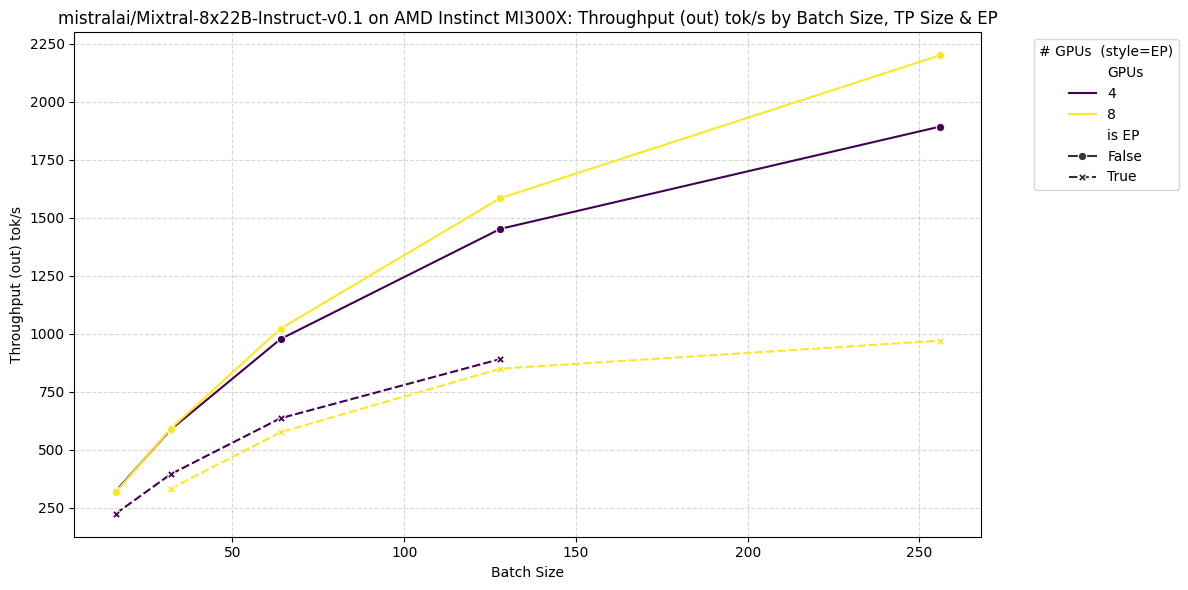

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


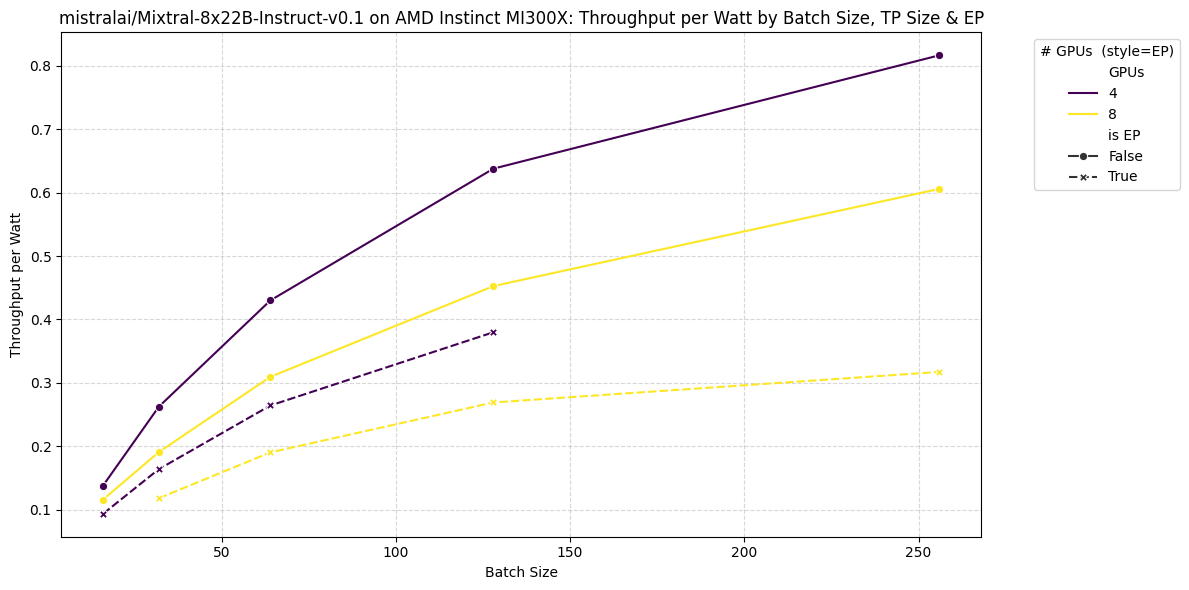

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


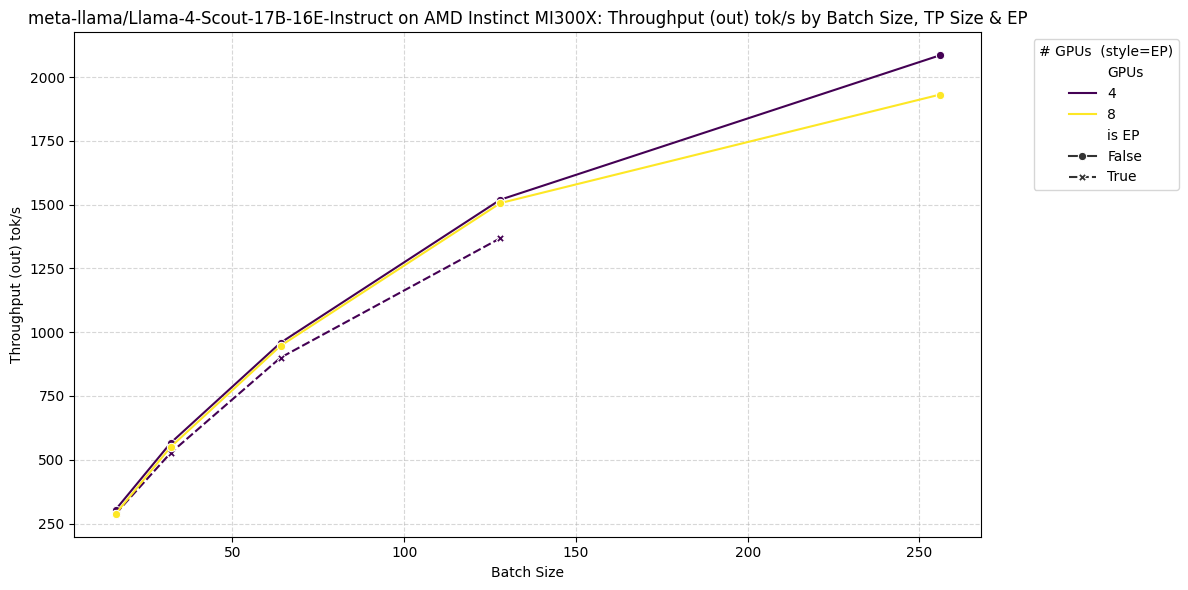

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


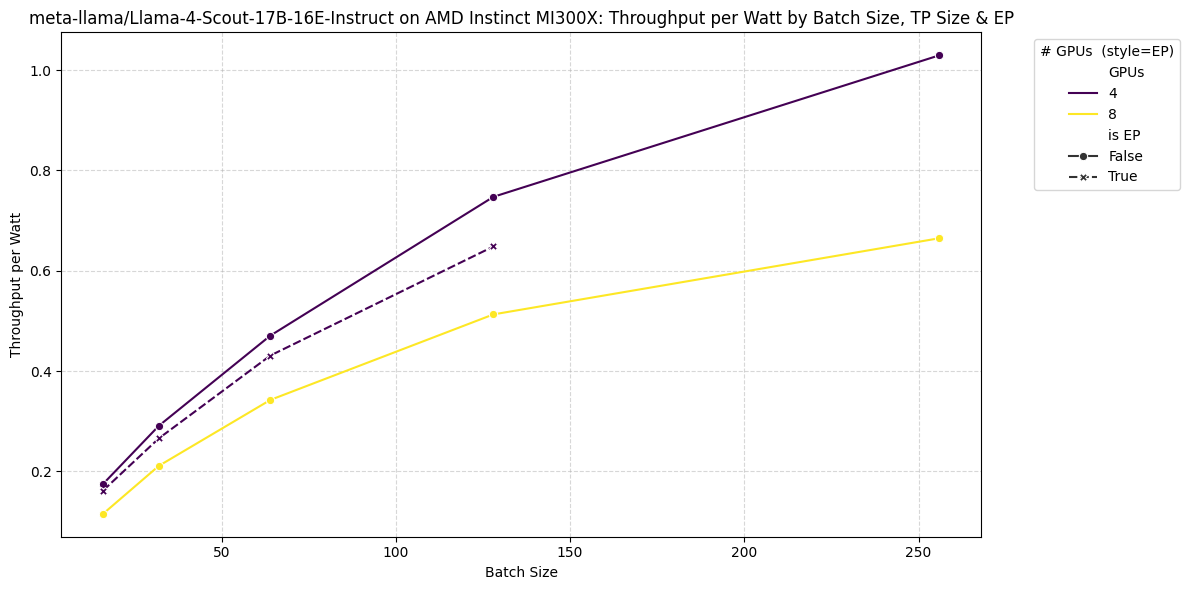

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


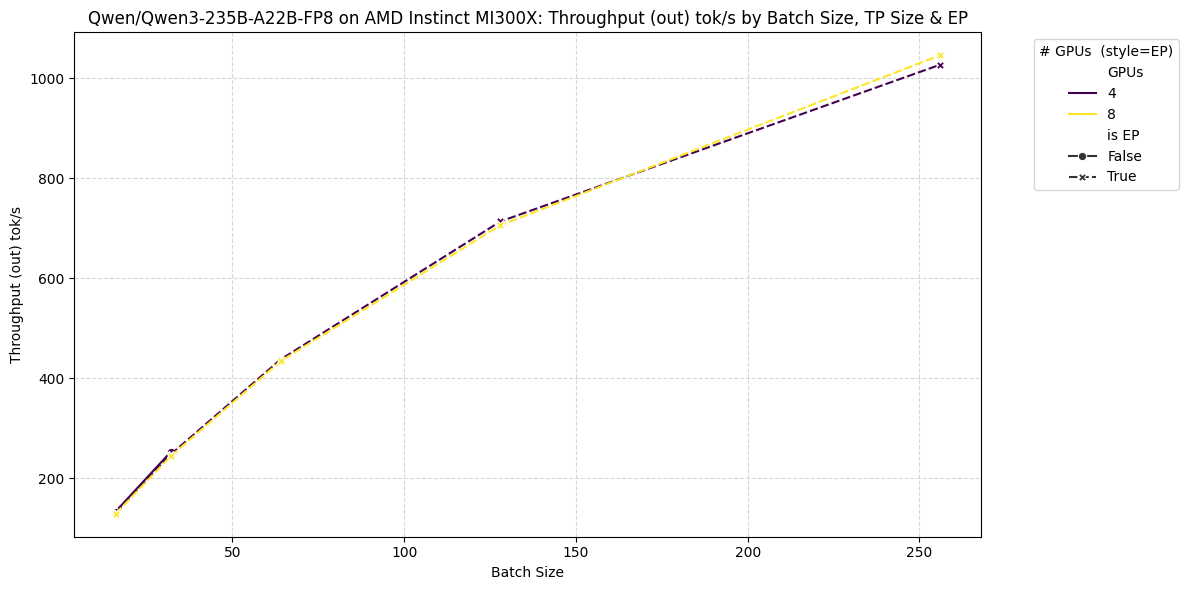

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


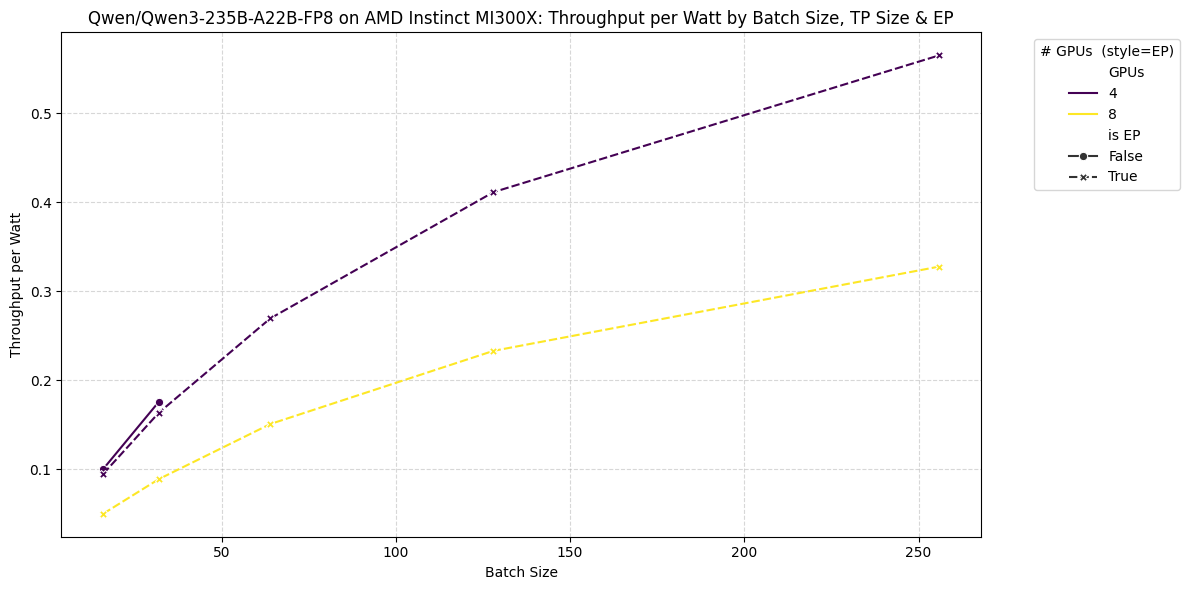

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


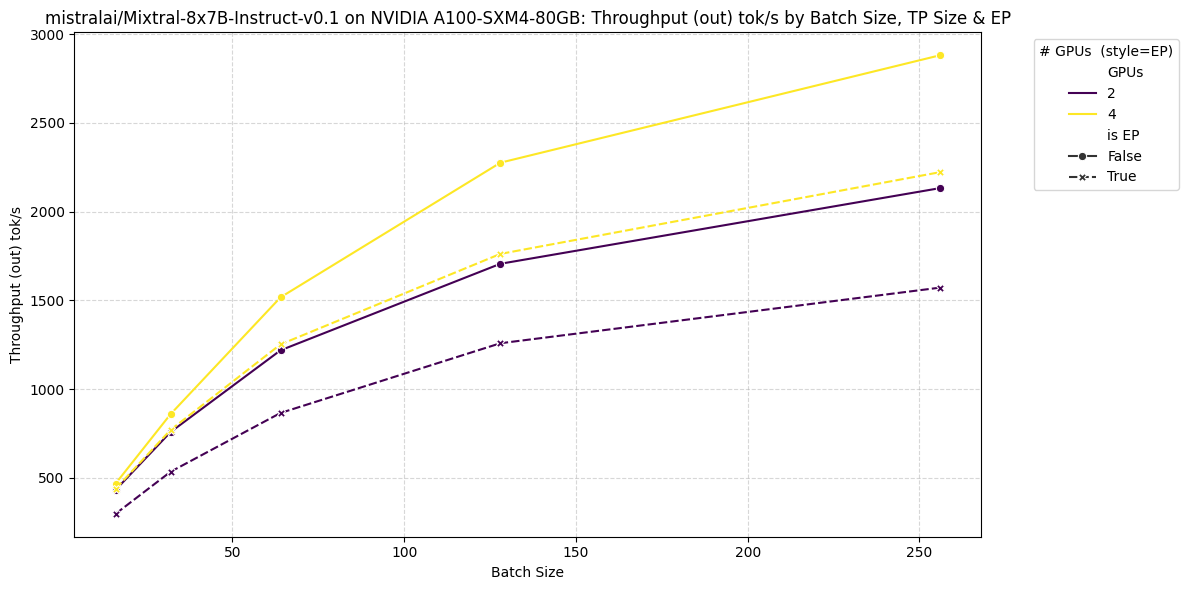

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


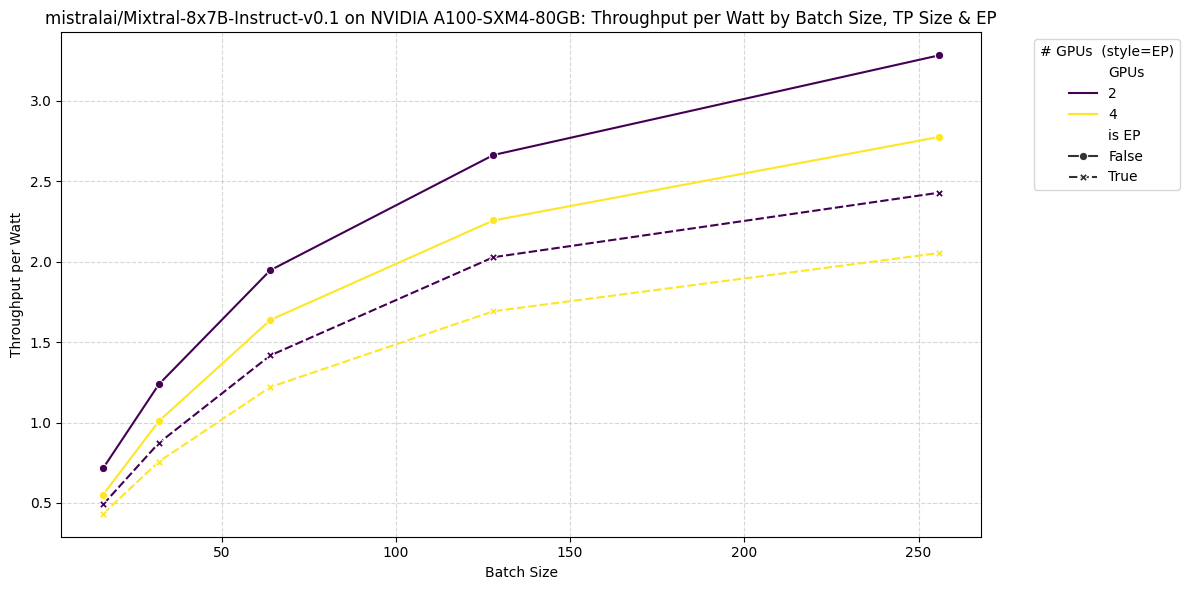

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


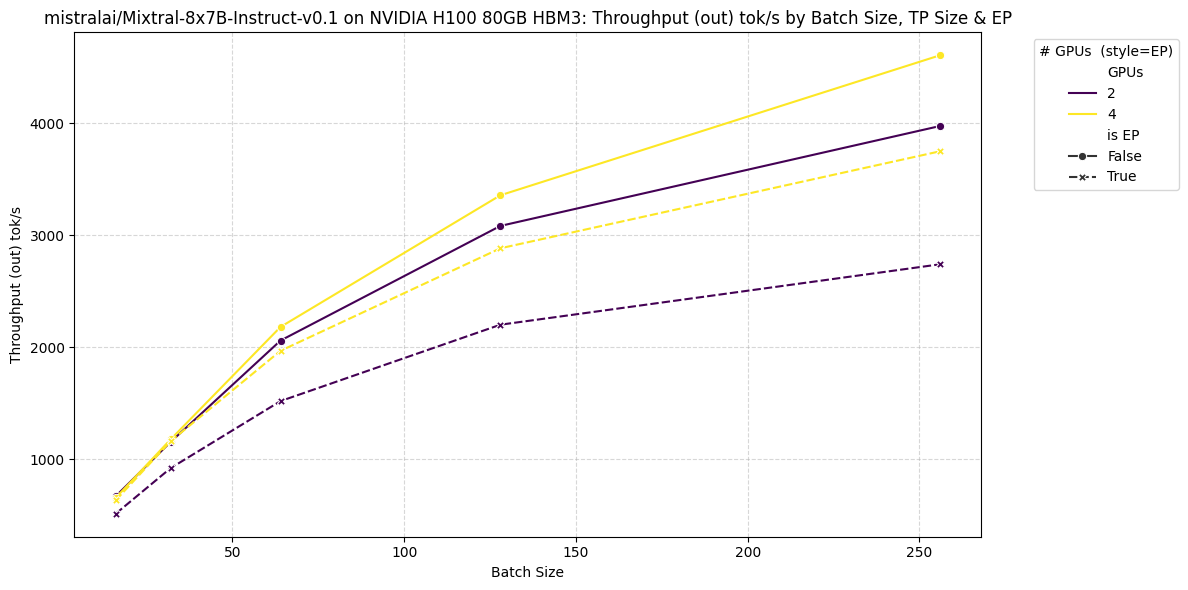

/tmp/ipykernel_230121/2146343399.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


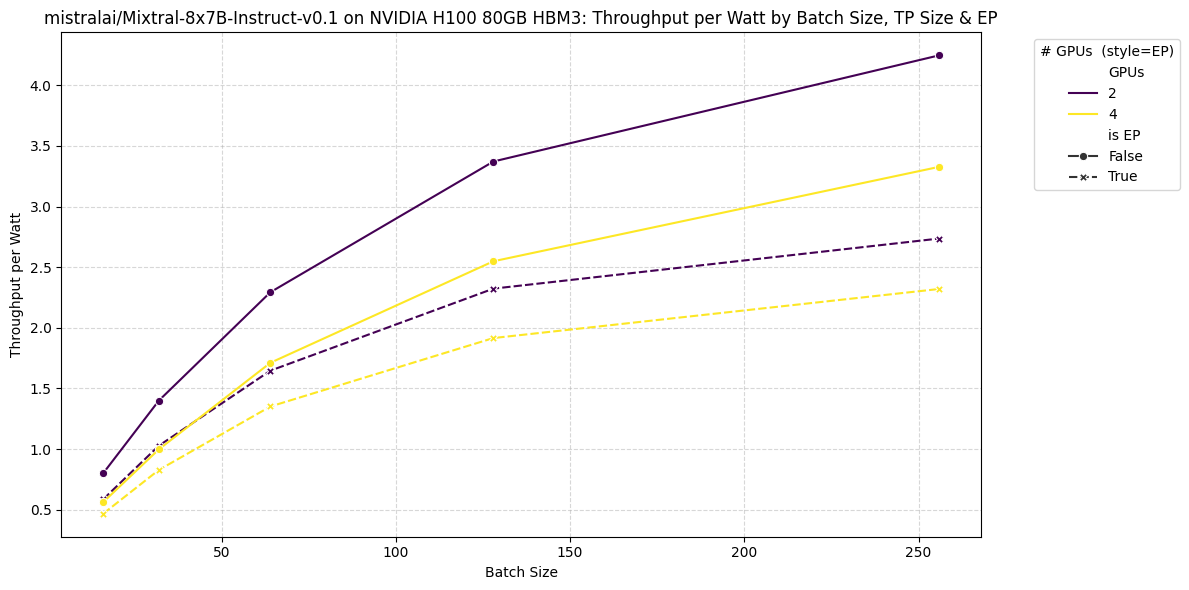

In [ ]:
metrics = [
    'Throughput (out) tok/s',
    'Throughput per Watt',
]

models = ['mistralai/Mixtral-8x7B-Instruct-v0.1',
    'mistralai/Mixtral-8x22B-Instruct-v0.1',
    'meta-llama/Llama-4-Scout-17B-16E-Instruct',
    'Qwen/Qwen3-235B-A22B-FP8']

for hw in ['AMD Instinct MI300X', 'NVIDIA A100-SXM4-80GB', 'NVIDIA H100 80GB HBM3']:
    for model_name in models:
        for metric in metrics:
            tp_vs_ep_metric(df, model_name, hw, metric)